# Data Science Individual Planning Stage  
**By: Ricky Shi**

---

## Data Description

This project uses two datasets, `players.csv` and `sessions.csv`, collected from a Minecraft research server operated by UBC’s Computer Science department. The data record player demographics and in-game activity. My analysis will primarily use `players.csv`, as it includes both predictors and the response variable

| Dataset | Rows | Columns | Description |
|----------|------|----------|--------------|
| `players.csv` | 196 | 7 | Contains hashed player IDs and variables such as age, gender, total playtime (hours), and newsletter subscription status |
| `sessions.csv` | 1535 | 5 | Contains session-level data, including player IDs, start and end times, and timestamp equivalents |

**Potential Issues**
- Missing age data in two observations could limit usable cases
- Outliers in play duration (e.g., idle sessions) may cause inaccurate playtimes
- Imbalanced subscription classes (few “No” cases) could affect classification accuracy
- Most variables are on different scales and require standardization

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data Summary

Below is a brief summary on the counts, maximum, minimum, and mean of each variable in both datasets.

In [18]:
players <- read_csv("data/players.csv") 

sessions <- read_csv("data/sessions.csv")


players_summary <- players |>
  summarize(
    total_players = n(),
    subscribed_players = sum(subscribe == TRUE, na.rm = TRUE),
    unsubscribed_players = sum(subscribe == FALSE, na.rm = TRUE),
    subscribed_percent = 100 * subscribed_players / total_players,
    age_mean = mean(Age, na.rm = TRUE),
    age_min  = min(Age, na.rm = TRUE),
    age_max  = max(Age, na.rm = TRUE),
    hours_mean = mean(played_hours, na.rm = TRUE),
    hours_min  = min(played_hours, na.rm = TRUE),
    hours_max  = max(played_hours, na.rm = TRUE)
  )

sessions_summary <- sessions |>
  count(hashedEmail, name = "session_count") |>
  summarize(
    total_players = n(),
    total_sessions = sum(session_count),
    avg_sessions_per_player = mean(session_count),
    min_sessions = min(session_count),
    max_sessions = max(session_count)
  )

players_summary
sessions_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


total_players,subscribed_players,unsubscribed_players,subscribed_percent,age_mean,age_min,age_max,hours_mean,hours_min,hours_max
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,144,52,73.46939,21.13918,9,58,5.845918,0,223.1


total_players,total_sessions,avg_sessions_per_player,min_sessions,max_sessions
<int>,<int>,<dbl>,<int>,<int>
125,1535,12.28,1,310


## **Establishing the Question**

**Broad Question:**  
What player characteristics and behaviors best predict newsletter subscription, and how do they differ between player types?

**Specific Question:**  
Can a player’s age and total playtime predict whether they subscribe to the game’s newsletter?

The `players.csv` dataset will be used to train a K-nearest neighbors (K-NN) classification model, since it contains all relevant variables. 

# Exploratory Data Analysis and Visualization

- For this section, I will use the `players` dataset to summarize the mean of the predictor variables, and visualize their relationships with newsletter subscription in a scatterplot
- Not much wrangling is needed as the dataset is already tidy for my analysis

In [12]:
# Mean summary of predictor variables
mean_summary <- players |>
  summarize(
    mean_age = mean(Age, na.rm = TRUE),
    mean_playtime = mean(played_hours, na.rm = TRUE),
  )

mean_summary

mean_age,mean_playtime
<dbl>,<dbl>
21.13918,5.845918


**Data Visualization**
- The scatterplot shows the relationship between age and total playtime, coloured by subscription status
- The bar plot compares the number of newsletter subscriptions across different skill levels
- The histograms visualize how playtime is distributed across subscribed and unsubscribed players
- Log10 scaling was used for the scatterplot and histograms to compress extreme values and improve the visibility of clustered data
  
**Observations**
- Across all plots containing playtime, most players had a low total playtime (below 10 hours)
- The scatterplot shows a weak negative relationship between playtime and age, where younger players tend to play more
- The histograms shows a clear trend where subscribers usually have more playtime
- The bar plot shows that at all experience levels, subscribers have more playtime, with amateurs and veterans having the most playtime

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


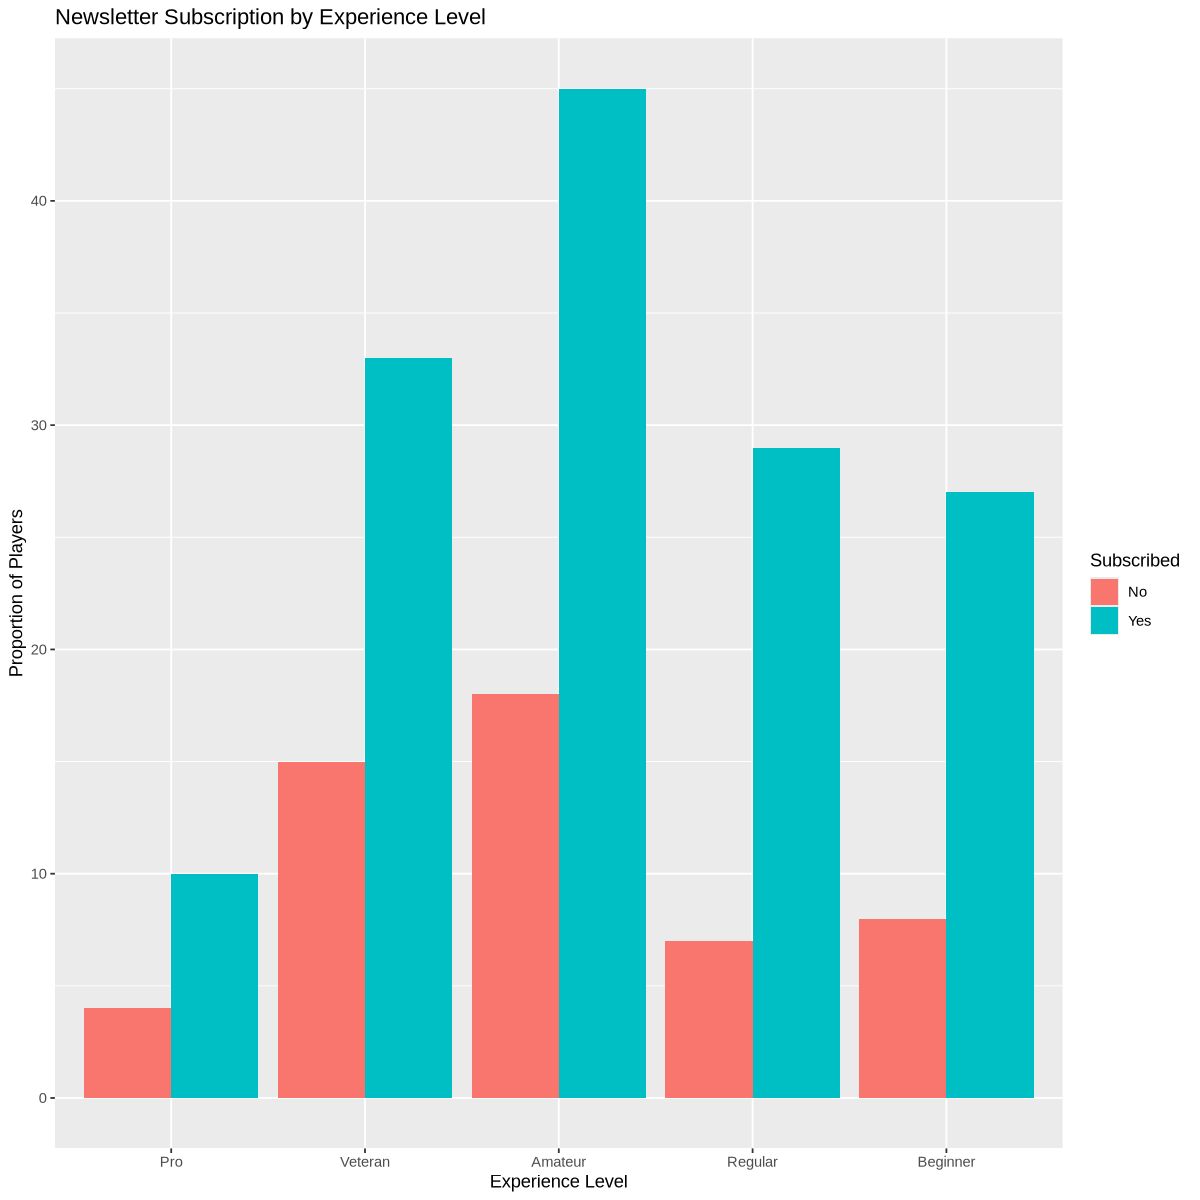

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


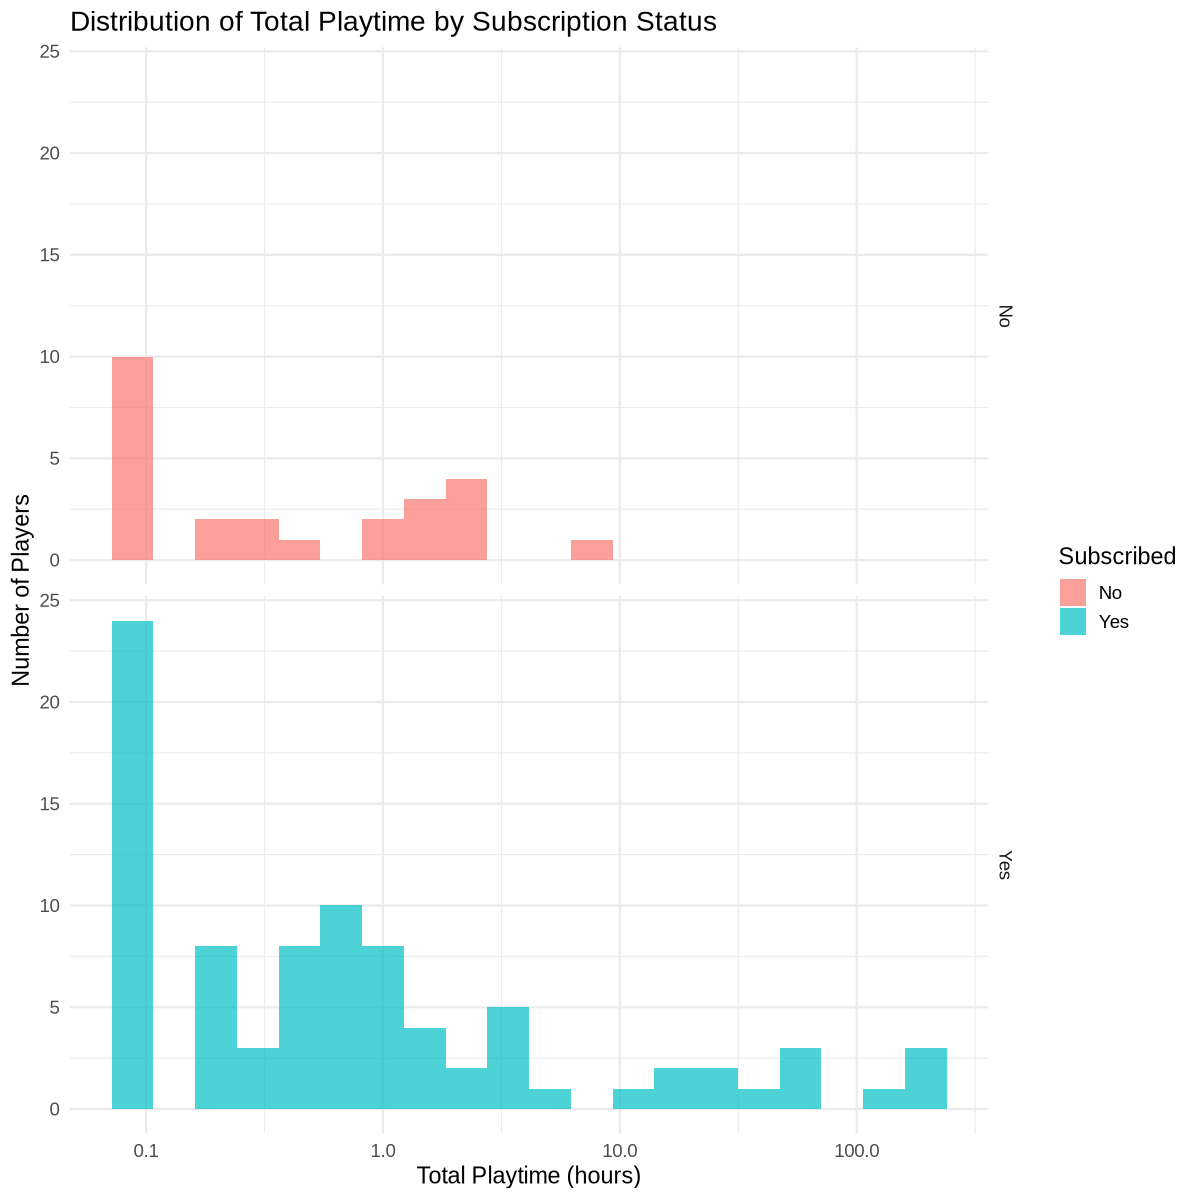

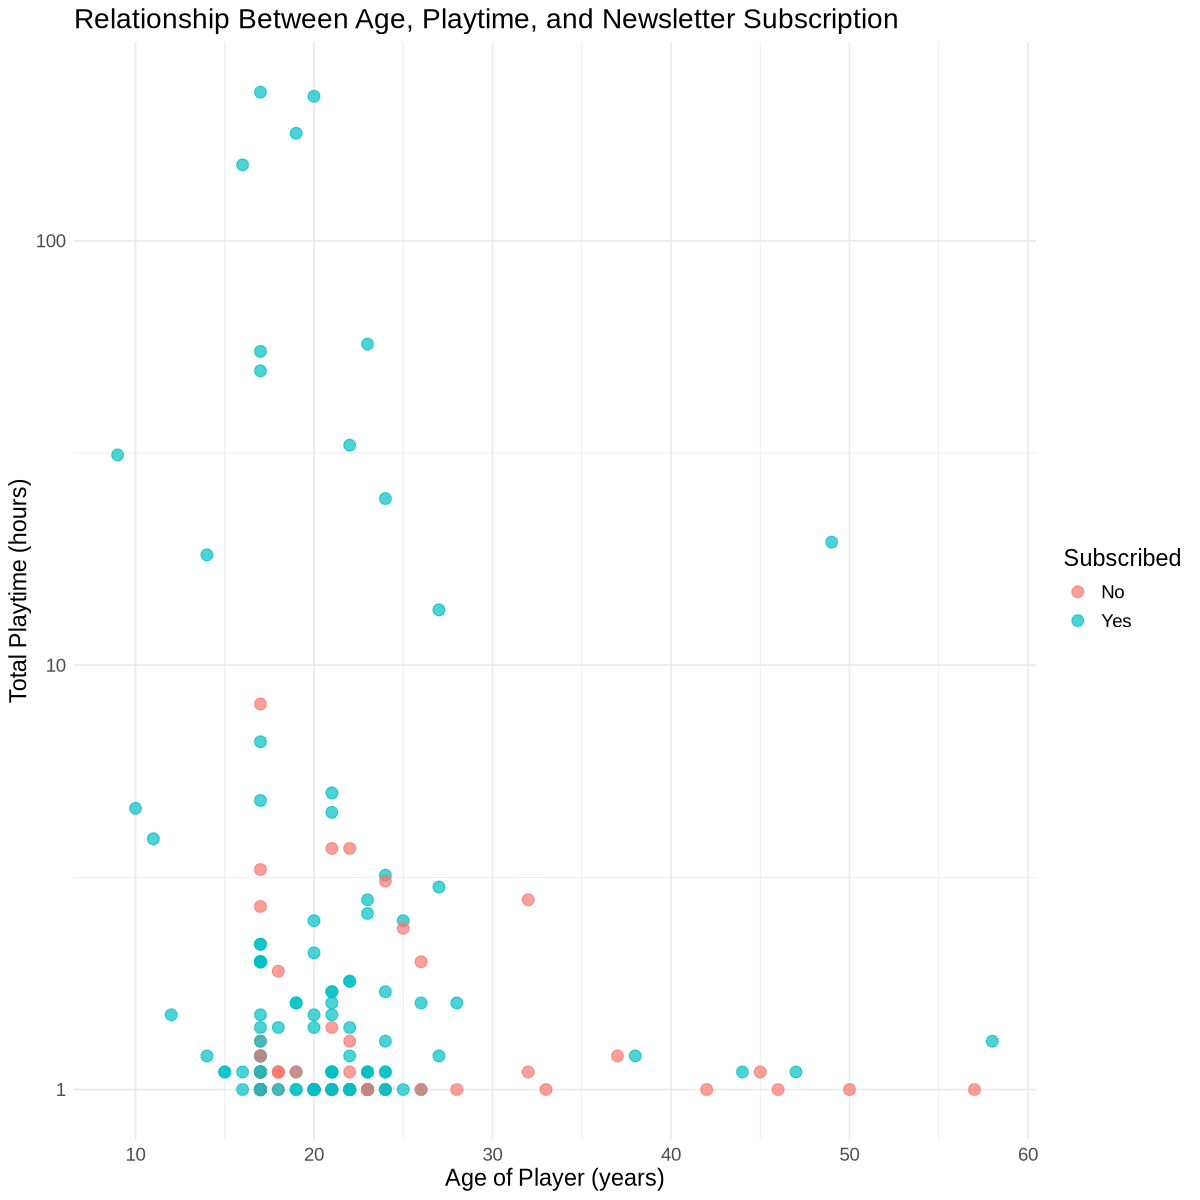

In [19]:
# Plot visualizations showing the relationships between multiple variables in the players dataset

options(repr.plot.width = 10, repr.plot.height = 10)

players <- players |>
  mutate(subscribe = as_factor(subscribe), subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"), experience = as_factor(experience))

players_plot <- ggplot(players, aes(x = Age, y = played_hours + 1, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  scale_y_log10() +
  labs(x = "Age of Player (years)", y = "Total Playtime (hours)", color = "Subscribed") +
  ggtitle("Relationship Between Age, Playtime, and Newsletter Subscription") +
  theme_minimal() +
  theme(text = element_text(size = 14))


players_barplot <- ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Newsletter Subscription by Experience Level", x = "Experience Level", y = "Proportion of Players", fill = "Subscribed")

players_histogram <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
  facet_grid(rows = vars(subscribe)) +
  scale_x_log10() +
  labs(title = "Distribution of Total Playtime by Subscription Status", x = "Total Playtime (hours)", y = "Number of Players", fill = "Subscribed") +
  theme_minimal(base_size = 14)

players_barplot
players_histogram
players_plot 

## Methods and Plan

A K-NN classification model will predict subscription status using age and playtime

**Why this model?**
- It is Suitable for categorical prediction using numerical predictors
- It does not require any particular relationship between the predictors and the outcome variables, but only uses nearby datapoints

**Assumptions & Preparation**
- Predictors will be standardized using scaling and centering
- Missing ages will be filled using the mean age

**Limitations**
- Class imbalance (more subscribers) can bias results  
- Extreme points could overly influence distance-based calculations

**Model Selection & Evaluation**
- I will Tune K (1–10) via 5-fold cross-validation using accuracy as the main metric
- Data is split into 70% training, 30% testing 
- The K with highest validation accuracy will be used to fit the final model and the accuracy on the test data will be used to answer the question